In [1]:
# Mount drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q /content/drive/MyDrive/hmud/fruit_dataset.zip

# 1. Load data


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf


class DataGenerator():
    def __init__(self, batch_size, target_size=(224, 224)):
        self.batch_size = batch_size
        self.target_size = target_size

    def generate_data(self, subset, directory):

        print("Loading", subset, "...")

        shuffle = False
        if subset == 'train' or subset == 'validation':
            shuffle = True

        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            class_names= [str(i) for i in range(0, 20)],
            color_mode='rgb',
            batch_size=self.batch_size,
            image_size=self.target_size,
            shuffle=shuffle,
            seed=42,
        )

        return dataset

In [5]:
def augmentation_layer(dataset):
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomBrightness(0.2),
        ]
    )
    aug_dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    return aug_dataset

In [20]:
batch_size = 32
target_size = (224, 224)
data_gen = DataGenerator(batch_size, target_size)

train_set = data_gen.generate_data('train', '/content/fruit_dataset/train')
val_set = data_gen.generate_data('validation', '/content/fruit_dataset/validate')
test_set = data_gen.generate_data('test', '/content/fruit_dataset/test')

Loading train ...
Found 8163 files belonging to 20 classes.
Loading validation ...
Found 2716 files belonging to 20 classes.
Loading test ...
Found 2716 files belonging to 20 classes.


In [21]:
# get labels for evaluating step
labels = np.array([])
for x, y in test_set:
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
print(len(labels))

2716


In [8]:
train_set = augmentation_layer(train_set)

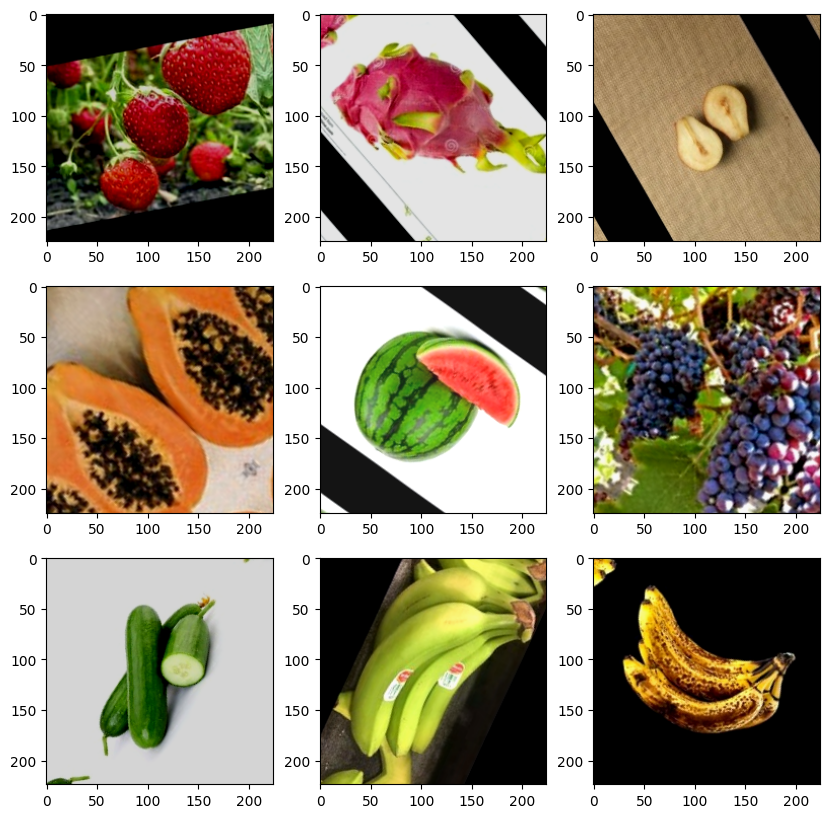

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

# 2. Define model/trainer/evaluator


## 2.1. Model class


In [10]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ReLU, Dense
from tensorflow.keras import Model


class ResNet:
    def __init__(self, num_classes=1000, input_shape=(224, 224, 3)):
        self.num_classes = num_classes
        self.input_shape = input_shape

    def _conv_batchnorm_relu(self, x, filters, kernel_size, strides=1):
        x = Conv2D(
            filters=filters, kernel_size=kernel_size, strides=strides, padding='same'
        )(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    def _identity_block(self, tensor, filters):
        x = self._conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
        x = self._conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
        x = Conv2D(filters=4 * filters, kernel_size=1, strides=1)(x)
        x = BatchNormalization()(x)
        x = Add()([tensor, x])
        x = ReLU()(x)
        return x

    def _projection_block(self, tensor, filters, strides):
        # left stream
        x = self._conv_batchnorm_relu(
            tensor, filters=filters, kernel_size=1, strides=strides
        )
        x = self._conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
        x = Conv2D(filters=4 * filters, kernel_size=1, strides=1)(x)
        x = BatchNormalization()(x)

        # right stream
        shortcut = Conv2D(filters=4 * filters, kernel_size=1, strides=strides)(tensor)
        shortcut = BatchNormalization()(shortcut)
        x = Add()([shortcut, x])  # skip connection
        x = ReLU()(x)
        return x

    def _resnet_block(self, x, filters, reps, strides):
        x = self._projection_block(x, filters, strides)
        for _ in range(reps - 1):
            x = self._identity_block(x, filters)
        return x

    def build(self):
        input = Input(shape=self.input_shape)

        x = self._conv_batchnorm_relu(input, filters=64, kernel_size=7, strides=2)
        x = MaxPool2D(pool_size=3, strides=2)(x)
        x = self._resnet_block(x, filters=64, reps=3, strides=1)
        x = self._resnet_block(x, filters=128, reps=4, strides=2)
        x = self._resnet_block(x, filters=256, reps=6, strides=2)
        x = self._resnet_block(x, filters=512, reps=3, strides=2)
        x = GlobalAvgPool2D()(x)

        output = Dense(units=self.num_classes, activation='softmax')(x)
        model = Model(inputs=input, outputs=output, name='resnet50')
        return model

In [11]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

class CustomModels:
    """Custom Model Class"""

    def __init__(self, num_classes=1000, input_shape=(224, 224, 3), name='resnet50'):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.name = name
        self.model = None

    def build(self):
        model = ResNet(self.num_classes, self.input_shape)
        self.model = model.build()
        return self.model

    def visualize(self):
        plot_model(self.model, show_shapes=True, to_file=self.name + '.png')
        image = Image(self.name + '.png')
        display(image)

    def summary(self):
        print(self.model.summary())

# 2.2 Define trainer


In [12]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os


class Trainer:
    def __init__(self, model, loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy']):
        self.model = model
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.history = None
        self.epochs = 0

    def compile(self):
        """
        Method to compile model with optimizer, loss and metrics
        """
        self.model.compile(optimizer=self.optimizer,
                           loss=self.loss,
                           metrics=self.metrics)

    def fit(self, train_set, val_set, batch_size, epochs, callbacks=[]):
        """
        Method to train model with dataset and return history
        """
        train_history = self.model.fit(train_set,
                                       batch_size=batch_size,
                                       epochs=epochs,
                                       validation_data=val_set,
                                       callbacks=callbacks)
        # history
        self.history = train_history.history
        self.epochs = len(train_history.history['val_loss'])

    def plot_history(self):
        """
        Method to plot model training history
        """

        fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

        axes[0].plot(self.history['accuracy'])
        axes[0].plot(self.history['val_accuracy'])
        axes[0].set_ylabel('Accuracy')
        axes[1].plot(self.history['loss'])
        axes[1].plot(self.history['val_loss'])
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')

        fig.suptitle('Model performance during training')
        axes[0].legend(('Train accuracy', 'Validation accuracy'))
        axes[1].legend(('Train loss', 'Validation loss'))

    def save_model(self, path='/content/drive/MyDrive/hmud/saved_model'):
        """
        Method to save model after training
        """

        save_path = os.path.join(path, f'{self.model.name}.h5')
        self.model.save(save_path)
        return save_path

# 2.3 Define evaluator


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report


class Evaluator:

    def __init__(self, model, test_set, y_true):
        self.model = model

        self.test_loss, self.test_acc = self.model.evaluate(
            test_set, verbose=1)

        y_pred = self.model.predict(test_set)
        y_pred = np.argmax(y_pred, axis=1)

        self.cm = confusion_matrix(y_true, y_pred)

        self.report = classification_report(y_true, y_pred)

    def evaluate(self):
        """
        Method to evaluate model and return loss and accuracy
        """
        return self.test_loss, self.test_acc

    def confusion_matrix(self):
        """
        Method to plot confusion matrix
        """
        plt.figure(figsize=(16, 8))
        sns.heatmap(self.cm, annot=True, fmt="d")
        plt.show()

    def classification_report(self):
        """
        Method to print classification report on test set
        """
        print(self.report)

# 3. Train/Test model


## 3.1. Create model


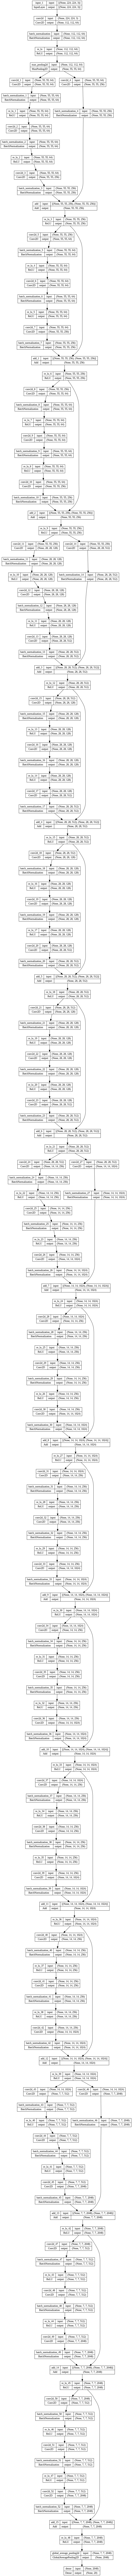

In [14]:
custom_model = CustomModels(num_classes=20, input_shape=(224, 224, 3), name='fruit_50epochs')
custom_model.build()
custom_model.visualize()

In [15]:
custom_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0

## 3.2. Train model


In [16]:
# Define hyperparameters for model trainer
import math
import os

epochs = 60
batch_size = 32

metrics = ['accuracy']
loss = tf.keras.losses.CategoricalCrossentropy()

initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch / epochs_drop))

checkpoint_filepath = os.path.join(
    '/content/drive/MyDrive/hmud/checkpoints',
    custom_model.model.name,
    "{epoch:03d}-{val_loss:.4f}.h5",
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=15
)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)

In [17]:
# Compile and train model
trainer = Trainer(custom_model.model, loss, optimizer, metrics)

# Compile model
trainer.compile()

# Train model
trainer.fit(train_set=train_set, val_set=val_set, batch_size=batch_size, epochs=epochs, callbacks=[lr_schedule, early_stopping, checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/60
256/256 [==============================] - 96s 244ms/step - loss: 2.6592 - accuracy: 0.2297 - val_loss: 2.5733 - val_accuracy: 0.2113 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/60
256/256 [==============================] - 57s 223ms/step - loss: 2.0815 - accuracy: 0.3348 - val_loss: 2.5905 - val_accuracy: 0.2835 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/60
256/256 [==============================] - 59s 228ms/step - loss: 1.8855 - accuracy: 0.4103 - val_loss: 2.0495 - val_accuracy: 0.3984 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/60
256/256 [==============================] - 57s 223ms/step - loss: 1.7764 - accuracy: 0.4337 - val_loss: 2.6332 - val_accuracy: 0.3166 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/60
256/256 [============================

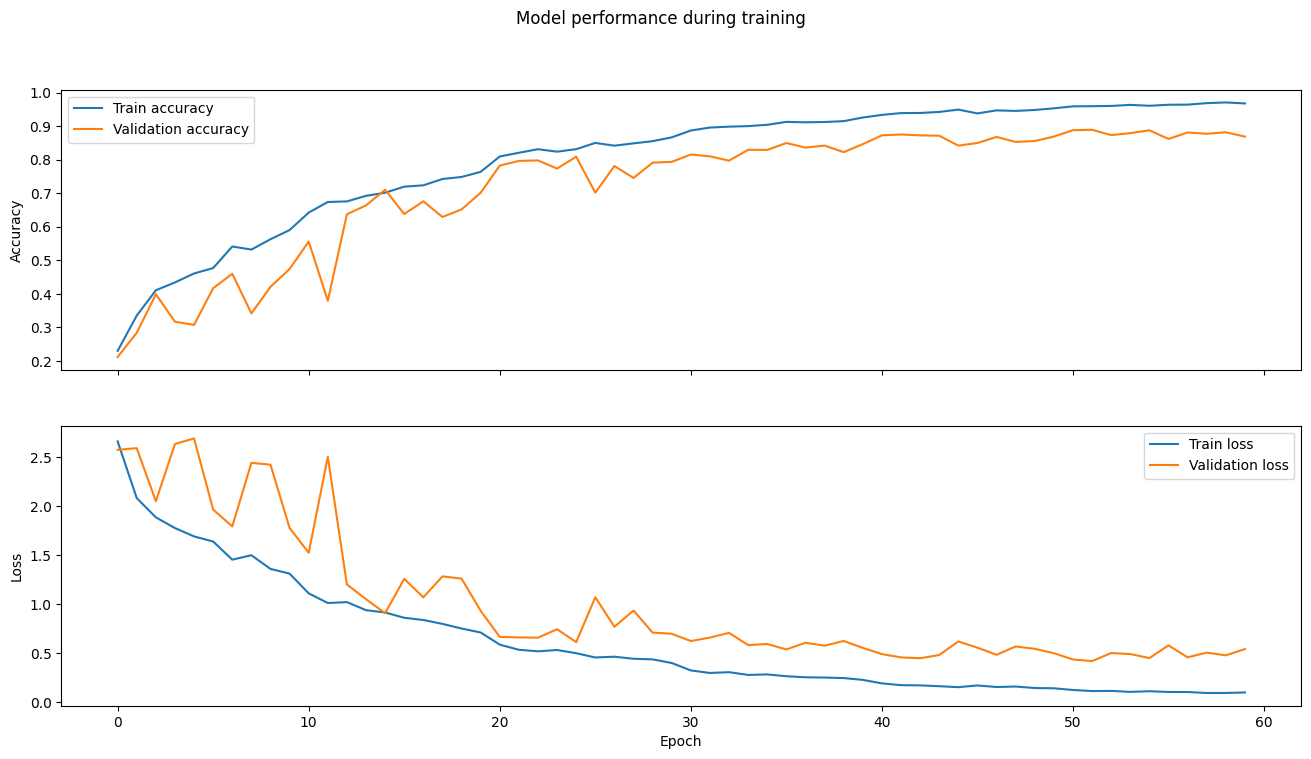

In [18]:
trainer.plot_history()

## 3.3. Evaluate model


In [22]:
evaluate = Evaluator(trainer.model, test_set, labels)

85/85 [==============================] - 3s 34ms/step


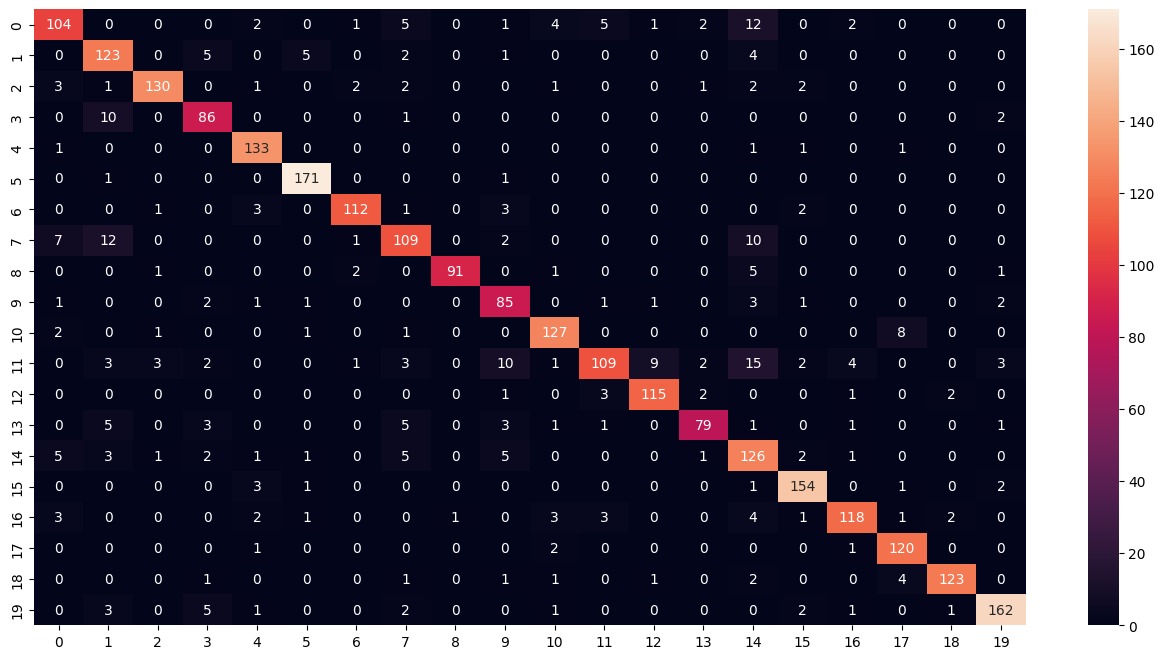

In [23]:
evaluate.confusion_matrix()

In [24]:
evaluate.classification_report()

              precision    recall  f1-score   support

         0.0       0.83      0.75      0.78       139
         1.0       0.76      0.88      0.82       140
         2.0       0.95      0.90      0.92       145
         3.0       0.81      0.87      0.84        99
         4.0       0.90      0.97      0.93       137
         5.0       0.94      0.99      0.97       173
         6.0       0.94      0.92      0.93       122
         7.0       0.80      0.77      0.78       141
         8.0       0.99      0.90      0.94       101
         9.0       0.75      0.87      0.81        98
        10.0       0.89      0.91      0.90       140
        11.0       0.89      0.65      0.75       167
        12.0       0.91      0.93      0.92       124
        13.0       0.91      0.79      0.84       100
        14.0       0.68      0.82      0.74       153
        15.0       0.92      0.95      0.94       162
        16.0       0.91      0.85      0.88       139
        17.0       0.89    

## 3.5. Save model


In [25]:
trainer.save_model()

'/content/drive/MyDrive/hmud/saved_model/resnet50.h5'

# 4. Inference


In [26]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import load_model
import cv2

fruit_classes = {
    0: "apple",
    1: "avocado",
    2: "banana",
    3: "cucumber",
    4: "dragonfruit",
    5: "durian",
    6: "grape",
    7: "guava",
    8: "kiwi",
    9: "lemon",
    10: "lychee",
    11: "mango",
    12: "orange",
    13: "papaya",
    14: "pear",
    15: "pineapple",
    16: "pomegranate",
    17: "strawberry",
    18: "tomato",
    19: "watermelon",
}

def resize_image(img_path, size=(224, 224)):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape) > 2 else 1
    if h == w:
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = (
        cv2.INTER_AREA if dif > (size[0] + size[1]) // 2 else cv2.INTER_CUBIC
    )

    x_pos = (dif - w) // 2
    y_pos = (dif - h) // 2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos : y_pos + h, x_pos : x_pos + w] = img[:h, :w]
    else:
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos : y_pos + h, x_pos : x_pos + w, :] = img[:h, :w, :]

    # return cv2.resize(mask, size, interpolation)
    mask = cv2.resize(mask, size, interpolation)
    cv2.imwrite(img_path, mask)


def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    x = img_to_array(img)
    # x /= 255
    x = np.expand_dims(x, axis=0)
    return x


def predict_image(image_data, model_path):
    model = load_model(model_path)

    prediction = model.predict(image_data)
    predicted_class = np.argmax(prediction)

    # Print prediction array in percentage format
    print(f"Prediction probabilities:")
    for i, class_prob in enumerate(prediction[0]):
        print(f"\t- {fruit_classes[i]}: {class_prob * 100:.2f}%")

    predicted_label = fruit_classes[predicted_class]
    return predicted_label

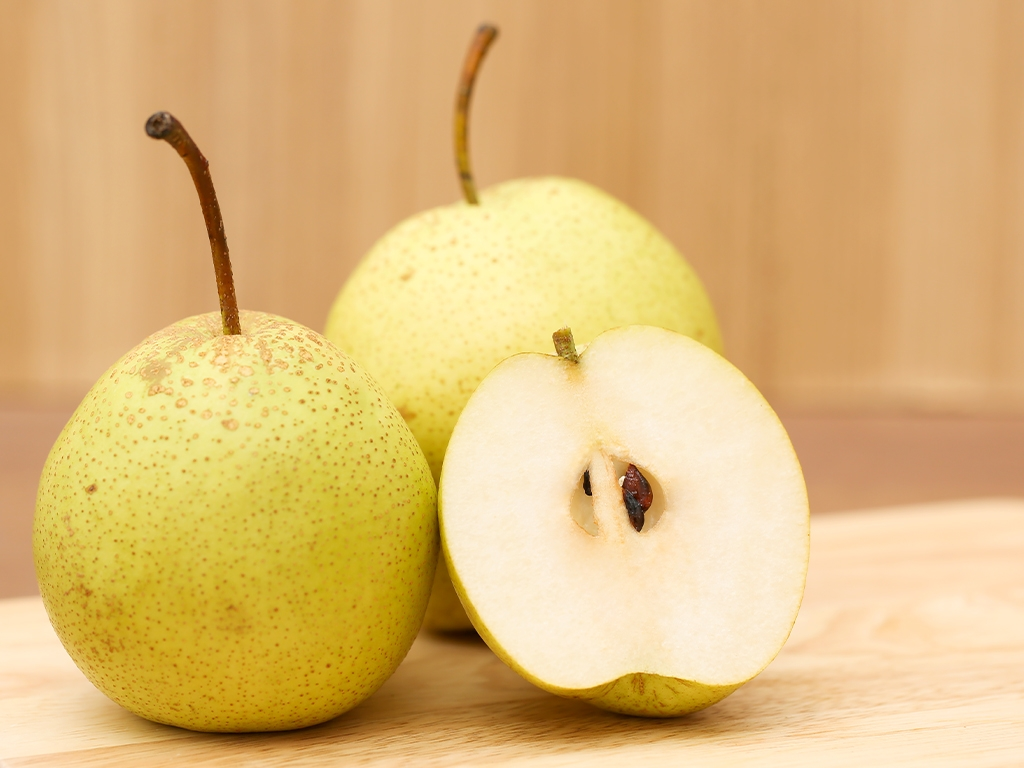

In [27]:
# download a fake image to test
from IPython.display import Image
import requests

URL = (
    "https://bizweb.dktcdn.net/thumb/1024x1024/100/433/551/products/le-duong-trung-quoc-hop-1kg-2-3-trai-202009111112244375.jpg?v=1631110920367"
)
response = requests.get(URL)

image_name = 'fruit.png'

with open(image_name, "wb") as f:
    f.write(response.content)

image = Image(image_name)
display(image)

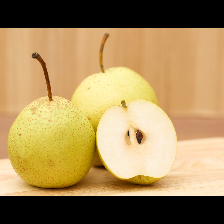

In [28]:
resize_image(image_name)
image = Image(image_name)
display(image)

In [29]:
# Preprocess image
image = preprocess_image(image_name)

# Load model from file
model_path = '/content/drive/MyDrive/hmud/saved_model/resnet50.h5'

# Predict image
predicted_class = predict_image(image, model_path)

print("Predicted class:", predicted_class)

1/1 [==============================] - 1s 1s/step
Prediction probabilities:
	- apple: 0.01%
	- avocado: 0.00%
	- banana: 0.00%
	- cucumber: 0.00%
	- dragonfruit: 0.00%
	- durian: 0.00%
	- grape: 0.00%
	- guava: 0.00%
	- kiwi: 0.00%
	- lemon: 0.00%
	- lychee: 0.00%
	- mango: 0.00%
	- orange: 0.00%
	- papaya: 0.00%
	- pear: 99.99%
	- pineapple: 0.00%
	- pomegranate: 0.00%
	- strawberry: 0.00%
	- tomato: 0.00%
	- watermelon: 0.00%
Predicted class: pear


## **Evaluate best checkpoint**

In [30]:
best_cp = '/content/drive/MyDrive/hmud/saved_model/rs88.h5'
best_model = load_model(best_cp)
evaluate = Evaluator(best_model, test_set, labels)


85/85 [==============================] - 4s 34ms/step


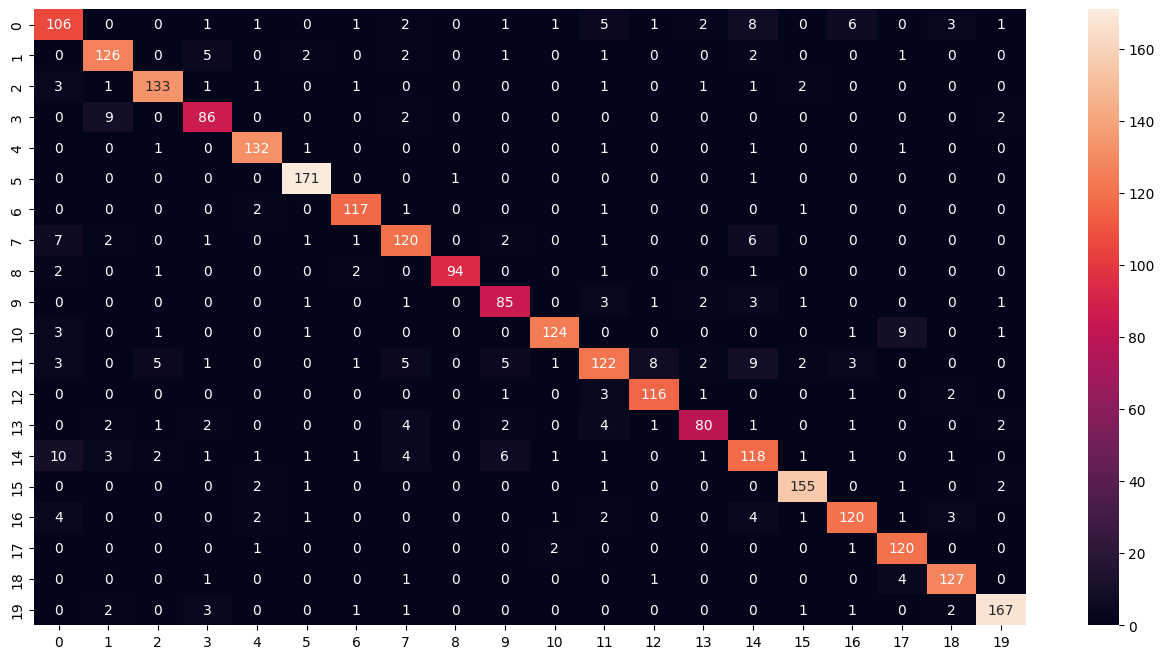

In [31]:
evaluate.confusion_matrix()

In [32]:
evaluate.classification_report()

              precision    recall  f1-score   support

         0.0       0.77      0.76      0.77       139
         1.0       0.87      0.90      0.88       140
         2.0       0.92      0.92      0.92       145
         3.0       0.84      0.87      0.86        99
         4.0       0.93      0.96      0.95       137
         5.0       0.95      0.99      0.97       173
         6.0       0.94      0.96      0.95       122
         7.0       0.84      0.85      0.85       141
         8.0       0.99      0.93      0.96       101
         9.0       0.83      0.87      0.85        98
        10.0       0.95      0.89      0.92       140
        11.0       0.83      0.73      0.78       167
        12.0       0.91      0.94      0.92       124
        13.0       0.90      0.80      0.85       100
        14.0       0.76      0.77      0.77       153
        15.0       0.95      0.96      0.95       162
        16.0       0.89      0.86      0.88       139
        17.0       0.88    